In [1]:
#==========Imports==========
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time
from scipy.optimize import curve_fit

import Bell_EBM as ebm

In [2]:
#==========Set Up System==========
in_rad = 1.900 #Times that or Jupiter
in_mass = 1.470 #Times that of Jupiter
in_orb = 1.09142030 #Orbital period in days
in_a = 0.02340*0.5 #Semi Major Axis in AU
in_inc = 83. #Planet's inclination
in_e = 0.6

s_in_teff = 6300.
s_in_rad = 1.59

#Allowed error ppm
aError = 100
resultsArray = np.zeros(shape=(2,4,4))

In [3]:
#==========High Temporal Res (Baseline) Creation==========
baseUpdates = 10000. #Amount of timesteps in baseline
baseOrbits = 5 #Amount of orbits in baseline

planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, e=in_e,nlat=8)
star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*baseOrbits
dt = system.planet.Porb/baseUpdates
baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (in_e != 0.):
    T0 = baselineMaps[-1]
    t0 = baselineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps)
else:
    baselineLightcurve = system.lightcurve()

In [4]:
#========== Tester Module - Temporal ==========

planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, e=in_e,nlat=8)
star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
system = ebm.System(star, planet)

nOrbits = 1 #Number of orbits

temporalArray = np.zeros(shape=(3,5))
temporalArray[0,0] = 1000.
temporalArray[0,1] = 500.
temporalArray[0,2] = 200.
temporalArray[0,3] = 100.
temporalArray[0,4] = 75.
#print(temporalArray)

for i in range(0, 5):
    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*nOrbits
    dt = system.planet.Porb/temporalArray[0,i]
    testTimes, testMaps, testTTC = system.run_model_tester(T0, t0, t1, dt, verbose=False)
    
    if (in_e != 0.):
        T0 = testMaps[-1]
        t0 = testTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        testTimes, testMaps, testttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
        testLightcurve = system.lightcurve(testTimes, testMaps)
    else:  
        testLightcurve = system.lightcurve()
    
    temporalArray[1,i] = testTTC*1e3
    temporalArray[2,i] = (np.amax(np.absolute(baselineLightcurve-testLightcurve)))*1e6
    

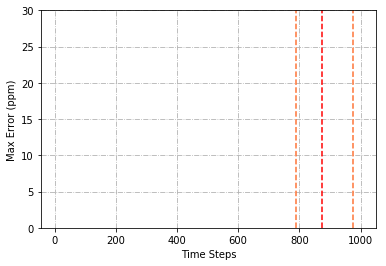

Temporal Resolutions: 790.0, 873.0, 974.0


In [5]:
plt.ylim(top=30)  # adjust the top leaving bottom unchanged
y = temporalArray[2,:]
x = temporalArray[0,:]

xa = np.linspace(5,1000,100)

popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
power_y = popt[0]*xa**-popt[1]
resultsArray[:,2,0] = round((aError/popt[0])**(1/(-popt[1])))
resultsArray[:,1,0] = round(((aError*1.1)/popt[0])**(1/(-popt[1])))
resultsArray[:,3,0] = round(((aError*0.9)/popt[0])**(1/(-popt[1])))

#Catch is implemented later

plt.scatter(x, y, label='actual data')
plt.plot(xa, power_y, label='power-fit')

plt.xlabel("Time Steps")
plt.ylabel("Max Error (ppm)")

plt.grid(True, linestyle='-.')
plt.axhline(y=aError, color='g', linestyle='--')
plt.axhline(y=aError*1.1, color='b', linestyle='--')
plt.axhline(y=aError*0.9, color='b', linestyle='--')

plt.axvline(x=resultsArray[0,1,0], color='#fe7335', linestyle='--')
plt.axvline(x=resultsArray[0,2,0], color='r', linestyle='--')
plt.axvline(x=resultsArray[0,3,0], color='#fe7335', linestyle='--')
plt.show()

print("Temporal Resolutions: "+str(resultsArray[0,1,0])+", "+str(resultsArray[0,2,0])+", "+str(resultsArray[0,3,0]))

In [6]:
#==========High Spacial Res (Baseline) Creation==========
baseUpdates = 500. #Amount of timesteps in baseline
baseOrbits = 1 #Amount of orbits in baseline#

planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, nlat = 128, e=in_e)
star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*baseOrbits
dt = system.planet.Porb/baseUpdates
baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (in_e != 0.):
    T0 = baselineMaps[-1]
    t0 = baselineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps)
else:
    baselineLightcurve = system.lightcurve()

In [7]:
#========== Tester Module - Spacial ==========

nOrbits = 1 #Number of orbits
nUpdates = 500.

spacialArray = np.zeros(shape=(3,5))
spacialArray[0,0] = 64.
spacialArray[0,1] = 32.
spacialArray[0,2] = 16.
spacialArray[0,3] = 8.
spacialArray[0,4] = 4.

for i in range(0, 5):
    planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, nlat = spacialArray[0,i], e=in_e)
    star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
    system = ebm.System(star, planet)
    
    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*nOrbits
    dt = system.planet.Porb/nUpdates
    testTimes, testMaps, testTTC = system.run_model_tester(T0, t0, t1, dt, verbose=False)
    
    if (in_e != 0.):
        T0 = testMaps[-1]
        t0 = testTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        testTimes, testMaps, testttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
        testLightcurve = system.lightcurve(testTimes, testMaps)
    else:  
        testLightcurve = system.lightcurve()
    
    spacialArray[1,i] = testTTC*1e3
    spacialArray[2,i] = (np.amax(np.absolute(baselineLightcurve-testLightcurve)))*1e6
print(spacialArray)

[[ 64.          32.          16.           8.           4.        ]
 [720.59512138 221.47512436 141.56389236 116.314888   102.43201256]
 [  2.72232046   7.63238293  16.8722135   82.32847022 415.29626163]]


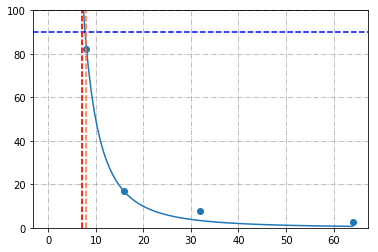

Spacial Resolutions: 7.0, 7.0, 8.0


In [8]:
plt.ylim(top=100)# adjust the top leaving bottom unchanged
y = spacialArray[2,:]
x = spacialArray[0,:]

xa = np.linspace(1e-6,64,100)
popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
power_y = popt[0]*xa**-popt[1]
resultsArray[:,0,2] = round((aError/popt[0])**(1/(-popt[1])))
resultsArray[:,0,1] = round(((aError*1.1)/popt[0])**(1/(-popt[1])))
resultsArray[:,0,3] = round(((aError*0.9)/popt[0])**(1/(-popt[1])))

for i in range (0,3):
    if (resultsArray[0,0,i+1] <=4):
        resultsArray[:,0,i+1] = 4

plt.scatter(x, y, label='actual data')
plt.plot(xa, power_y, label='power-fit')
plt.grid(True, linestyle='-.')

plt.axhline(y=aError, color='g', linestyle='--')
plt.axhline(y=aError*1.1, color='b', linestyle='--')
plt.axhline(y=aError*0.9, color='b', linestyle='--')

plt.axvline(x=resultsArray[0,0,1], color='#fe7335', linestyle='--')
plt.axvline(x=resultsArray[0,0,2], color='r', linestyle='--')
plt.axvline(x=resultsArray[0,0,3], color='#fe7335', linestyle='--')
plt.show()

print("Spacial Resolutions: "+str(resultsArray[0,0,1])+", "+str(resultsArray[0,0,2])+", "+str(resultsArray[0,0,3]))

In [9]:
#==========High Spacial Res (Baseline) Creation==========
baseUpdates = 10000. #Amount of timesteps in baseline
baseOrbits = 3 #Amount of orbits in baseline

planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, nlat = 128, e=in_e)
star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*baseOrbits
dt = system.planet.Porb/baseUpdates
baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (in_e != 0.):
    T0 = baselineMaps[-1]
    t0 = baselineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps)
else:
    baselineLightcurve = system.lightcurve()

In [10]:
dtMax = 0.5/system.planet.wind_dlon/24/3600
dtMax = np.floor(dtMax*1e5)/1e5
timestepMin = in_orb/dtMax
for i in range (0,3):
    if (resultsArray[0,i+1,0] <=timestepMin):
        resultsArray[:,i+1,0] = np.ceil(timestepMin)

for i in range(0,3):
    planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, e=in_e,
                    nlat=resultsArray[0,0,(i+1)])
    star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
    system = ebm.System(star, planet)
    for j in range(0,3):
        for k in range(0,3):
            Teq = system.get_teq()
            T0 = np.ones_like(system.planet.map.values)*Teq
            t0 = 0.
            t1 = t0+system.planet.Porb*1
            dt = system.planet.Porb/resultsArray[0,(j+1),0]
            testTimes, testMaps, testTTC = system.run_model_tester(T0, t0, t1, dt, verbose=False)
            
            if (in_e != 0.):
                T0 = testMaps[-1]
                t0 = testTimes[-1]
                t1 = t0+system.planet.Porb
                dt = (system.planet.Porb)/1000.
                testTimes, testMaps, testttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
                testLightcurve = system.lightcurve(testTimes, testMaps)
            else:  
                testLightcurve = system.lightcurve()
                
            resultsArray[0,(j+1),(i+1)] += testTTC
            resultsArray[1,(j+1),(i+1)] += (np.amax(np.absolute(baselineLightcurve-testLightcurve)))*1e6
        resultsArray[0,(j+1),(i+1)] = resultsArray[0,(j+1),(i+1)]/3
        resultsArray[1,(j+1),(i+1)] = resultsArray[1,(j+1),(i+1)]/3
print(resultsArray)

[[[0.00000000e+00 7.00000000e+00 7.00000000e+00 8.00000000e+00]
  [7.90000000e+02 2.43690968e-01 2.38017082e-01 1.82518403e-01]
  [8.73000000e+02 2.59599209e-01 2.25306352e-01 2.05013355e-01]
  [9.74000000e+02 2.34397332e-01 2.28683710e-01 2.26717790e-01]]

 [[0.00000000e+00 7.00000000e+00 7.00000000e+00 8.00000000e+00]
  [7.90000000e+02 1.97923920e+02 1.97923920e+02 1.68092553e+02]
  [8.73000000e+02 1.93862773e+02 1.93862773e+02 1.59336444e+02]
  [9.74000000e+02 1.89857747e+02 1.89857747e+02 1.50643081e+02]]]


In [11]:
lowi = None
lowj = None
lowestNumber = 1e20
for i in range(0,3):
    for j in range(0,3):
        if ((resultsArray[1,(j+1),(i+1)]<=aError) and (resultsArray[0,(j+1),(i+1)]<lowestNumber)):
            lowestNumber=(resultsArray[0,(j+1),(i+1)])
            lowi=i+1
            lowj=j+1
            
if (lowi == None):
    for i in range(0,3):
        for j in range(0,3):
            if ((resultsArray[0,(j+1),(i+1)]<lowestNumber)):
                lowestNumber=(resultsArray[0,(j+1),(i+1)])
                lowi=i+1
                lowj=j+1
    
#print(lowestNumber)
print("Lowest i: " + str(lowi)+", Lowest j: " + str(lowj))
print(lowj)
print("Expected accuracy loss " + str(round(resultsArray[1,lowj,lowi],3)) + " ppm")
print("Expected time to complete " + str(round(resultsArray[0,lowj,lowi]*1e6/3600,3)) + " hours")

Lowest i: 3, Lowest j: 1
1
Expected accuracy loss 168.093 ppm
Expected time to complete 50.7 hours


In [12]:
print(resultsArray)

[[[0.00000000e+00 7.00000000e+00 7.00000000e+00 8.00000000e+00]
  [7.90000000e+02 2.43690968e-01 2.38017082e-01 1.82518403e-01]
  [8.73000000e+02 2.59599209e-01 2.25306352e-01 2.05013355e-01]
  [9.74000000e+02 2.34397332e-01 2.28683710e-01 2.26717790e-01]]

 [[0.00000000e+00 7.00000000e+00 7.00000000e+00 8.00000000e+00]
  [7.90000000e+02 1.97923920e+02 1.97923920e+02 1.68092553e+02]
  [8.73000000e+02 1.93862773e+02 1.93862773e+02 1.59336444e+02]
  [9.74000000e+02 1.89857747e+02 1.89857747e+02 1.50643081e+02]]]


In [13]:
in_orb/dtMax

283.4857922077922